## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

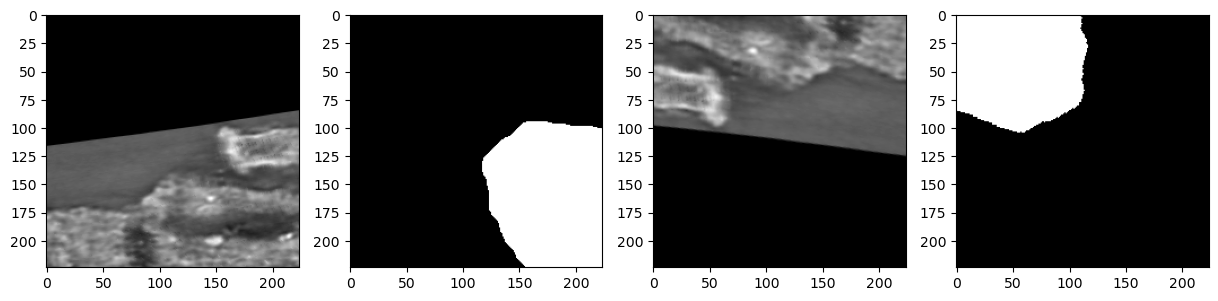

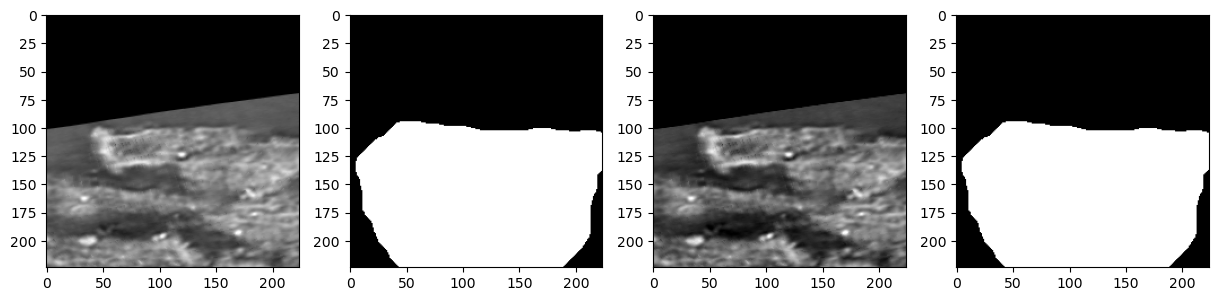

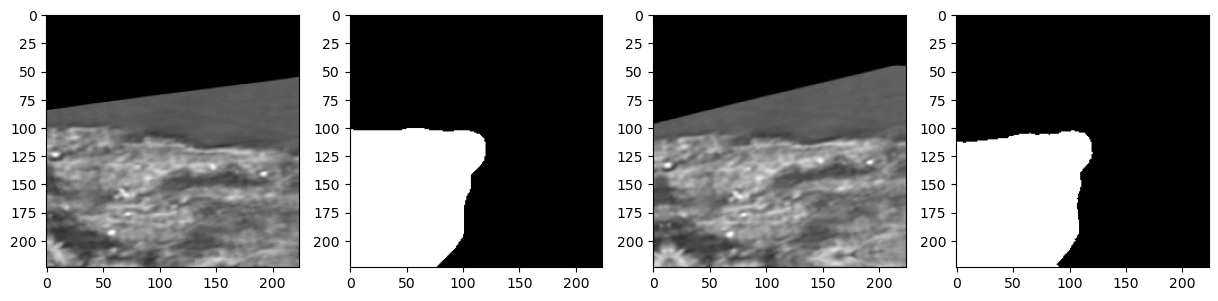

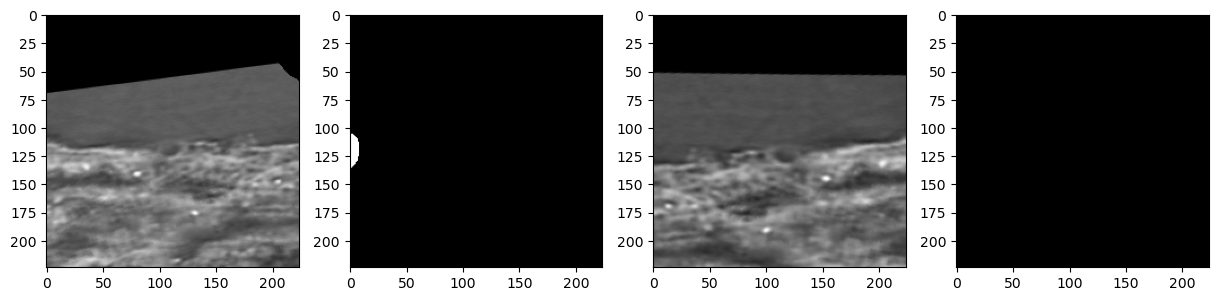

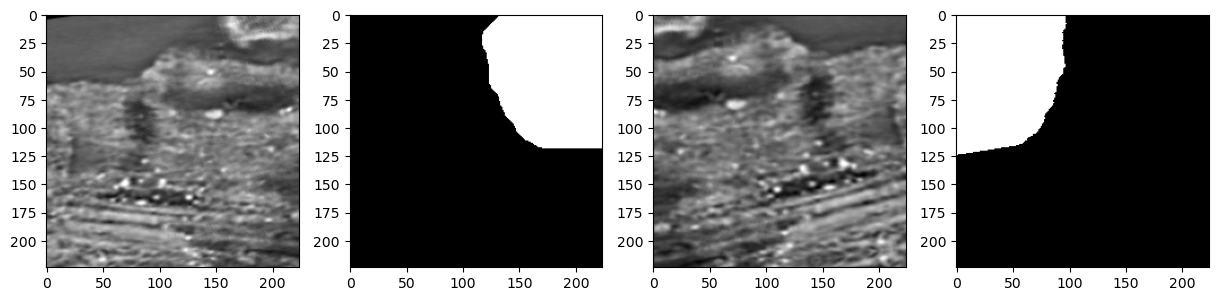

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48145

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1420844657820236
th: 0.15, fbeta: 0.1420499957594758
th: 0.2, fbeta: 0.14189312388066042
th: 0.25, fbeta: 0.14222351163185956
th: 0.3, fbeta: 0.1950098276986097
th: 0.35, fbeta: 0.21379216426721
th: 0.4, fbeta: 0.22715316493183738
th: 0.45, fbeta: 0.2386417476635274


best_th: 0.45, fbeta: 0.2386417476635274
Epoch 1 - avg_train_loss: 0.6732  avg_val_loss: 0.5108  time: 119s
Epoch 1 - avgScore: 0.2386
Epoch 1 - Save Best Score: 0.2386 Model
Epoch 1 - Save Best Loss: 0.5108 Model


th: 0.5, fbeta: 0.23819048360494915


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209270588989825
th: 0.15, fbeta: 0.14209002190166836
th: 0.2, fbeta: 0.14409005997359042
th: 0.25, fbeta: 0.2015531538880265
th: 0.3, fbeta: 0.23080177561750911
th: 0.35, fbeta: 0.2555020329784006
th: 0.4, fbeta: 0.24916736902878958
th: 0.45, fbeta: 0.20176534316531128


best_th: 0.35, fbeta: 0.2555020329784006
Epoch 2 - avg_train_loss: 0.4704  avg_val_loss: 0.4241  time: 118s
Epoch 2 - avgScore: 0.2555
Epoch 2 - Save Best Score: 0.2555 Model
Epoch 2 - Save Best Loss: 0.4241 Model


th: 0.5, fbeta: 0.1467067753967683


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.32029006513227376
th: 0.15, fbeta: 0.38696171806405044
th: 0.2, fbeta: 0.40769977295046345
th: 0.25, fbeta: 0.4013877854343317
th: 0.3, fbeta: 0.3821845095057004
th: 0.35, fbeta: 0.3547404753870908
th: 0.4, fbeta: 0.31932370368643614
th: 0.45, fbeta: 0.2771762874488879


best_th: 0.2, fbeta: 0.40769977295046345
Epoch 3 - avg_train_loss: 0.2804  avg_val_loss: 0.3196  time: 118s
Epoch 3 - avgScore: 0.4077
Epoch 3 - Save Best Score: 0.4077 Model
Epoch 3 - Save Best Loss: 0.3196 Model


th: 0.5, fbeta: 0.23301320273185835


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38334654845722865
th: 0.15, fbeta: 0.3269126094007051
th: 0.2, fbeta: 0.2404864537935279
th: 0.25, fbeta: 0.1646115987131305
th: 0.3, fbeta: 0.10994772219656448
th: 0.35, fbeta: 0.07468683122227578
th: 0.4, fbeta: 0.049156745361405615
th: 0.45, fbeta: 0.03114713379311801


best_th: 0.1, fbeta: 0.38334654845722865
Epoch 4 - avg_train_loss: 0.2047  avg_val_loss: 0.3700  time: 120s
Epoch 4 - avgScore: 0.3833


th: 0.5, fbeta: 0.019376403752084496


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36551255700815016
th: 0.15, fbeta: 0.2377033561110177
th: 0.2, fbeta: 0.16626240058194286
th: 0.25, fbeta: 0.1251844047461071
th: 0.3, fbeta: 0.09484757250574338
th: 0.35, fbeta: 0.07134218663952087
th: 0.4, fbeta: 0.054868636237403776
th: 0.45, fbeta: 0.042322182272242596


best_th: 0.1, fbeta: 0.36551255700815016
Epoch 5 - avg_train_loss: 0.1910  avg_val_loss: 0.4285  time: 118s
Epoch 5 - avgScore: 0.3655


th: 0.5, fbeta: 0.033335982029137526


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2761349323481716
th: 0.15, fbeta: 0.17715557804541124
th: 0.2, fbeta: 0.12848208653935442
th: 0.25, fbeta: 0.0987850601989886
th: 0.3, fbeta: 0.07380801277597845
th: 0.35, fbeta: 0.05289307231628659
th: 0.4, fbeta: 0.035566211418051545
th: 0.45, fbeta: 0.022699332811073357


best_th: 0.1, fbeta: 0.2761349323481716
Epoch 6 - avg_train_loss: 0.1808  avg_val_loss: 0.4709  time: 116s
Epoch 6 - avgScore: 0.2761


th: 0.5, fbeta: 0.015039513801139458


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41785710455473885
th: 0.15, fbeta: 0.37195592661622623
th: 0.2, fbeta: 0.3016921453390558
th: 0.25, fbeta: 0.25524685560764276
th: 0.3, fbeta: 0.21528596447629378
th: 0.35, fbeta: 0.17697731509768846
th: 0.4, fbeta: 0.14283687180034926
th: 0.45, fbeta: 0.11325173174357514


best_th: 0.1, fbeta: 0.41785710455473885
Epoch 7 - avg_train_loss: 0.1716  avg_val_loss: 0.4138  time: 116s
Epoch 7 - avgScore: 0.4179
Epoch 7 - Save Best Score: 0.4179 Model
Epoch 7 - Save Best Loss: 0.4138 Model


th: 0.5, fbeta: 0.08732793354733119


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38412335378891477
th: 0.15, fbeta: 0.4034959857103206
th: 0.2, fbeta: 0.3898921054100022
th: 0.25, fbeta: 0.36873633502090136
th: 0.3, fbeta: 0.33386267369668093
th: 0.35, fbeta: 0.292969933533234
th: 0.4, fbeta: 0.25106540212402634
th: 0.45, fbeta: 0.2124135678197256


best_th: 0.15, fbeta: 0.4034959857103206
Epoch 8 - avg_train_loss: 0.1629  avg_val_loss: 0.3912  time: 121s
Epoch 8 - avgScore: 0.4035


th: 0.5, fbeta: 0.17456432385796125


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3925387206816568
th: 0.15, fbeta: 0.40158838618738596
th: 0.2, fbeta: 0.3979214115744708
th: 0.25, fbeta: 0.389403203247941
th: 0.3, fbeta: 0.37672328493455215
th: 0.35, fbeta: 0.35705432054389125
th: 0.4, fbeta: 0.3272359952208195
th: 0.45, fbeta: 0.2919405713752321


best_th: 0.15, fbeta: 0.40158838618738596
Epoch 9 - avg_train_loss: 0.1545  avg_val_loss: 0.4030  time: 119s
Epoch 9 - avgScore: 0.4016


th: 0.5, fbeta: 0.2575850798097009


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36045339332733056
th: 0.15, fbeta: 0.3634335672977262
th: 0.2, fbeta: 0.35379042077190037
th: 0.25, fbeta: 0.3366753063125145
th: 0.3, fbeta: 0.30581987887493367
th: 0.35, fbeta: 0.2704926801368067
th: 0.4, fbeta: 0.2321386727290254
th: 0.45, fbeta: 0.18740076781590348


best_th: 0.15, fbeta: 0.3634335672977262
Epoch 10 - avg_train_loss: 0.1444  avg_val_loss: 0.4664  time: 120s
Epoch 10 - avgScore: 0.3634


th: 0.5, fbeta: 0.14666840658905234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39231774563200017
th: 0.15, fbeta: 0.3948866341542914
th: 0.2, fbeta: 0.39059115694542823
th: 0.25, fbeta: 0.37886026569294534
th: 0.3, fbeta: 0.3637898209459133
th: 0.35, fbeta: 0.3431648193894025
th: 0.4, fbeta: 0.3185607806583323
th: 0.45, fbeta: 0.29085807837084543


best_th: 0.15, fbeta: 0.3948866341542914
Epoch 11 - avg_train_loss: 0.1363  avg_val_loss: 0.4501  time: 117s
Epoch 11 - avgScore: 0.3949


th: 0.5, fbeta: 0.2621301901361349


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36149424852620093
th: 0.15, fbeta: 0.32454692644272637
th: 0.2, fbeta: 0.2802447193012576
th: 0.25, fbeta: 0.23610840129545219
th: 0.3, fbeta: 0.20066380846666046
th: 0.35, fbeta: 0.17014926023144175
th: 0.4, fbeta: 0.14258151245556253
th: 0.45, fbeta: 0.11815639168834692


best_th: 0.1, fbeta: 0.36149424852620093
Epoch 12 - avg_train_loss: 0.1257  avg_val_loss: 0.5160  time: 117s
Epoch 12 - avgScore: 0.3615


th: 0.5, fbeta: 0.09752131201594123


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3910267999865494
th: 0.15, fbeta: 0.3761616553548706
th: 0.2, fbeta: 0.3561258436052053
th: 0.25, fbeta: 0.32912084028683913
th: 0.3, fbeta: 0.29999921508042715
th: 0.35, fbeta: 0.2699174190072933
th: 0.4, fbeta: 0.24163994274263867
th: 0.45, fbeta: 0.2147020352008778


best_th: 0.1, fbeta: 0.3910267999865494
Epoch 13 - avg_train_loss: 0.1188  avg_val_loss: 0.5548  time: 118s
Epoch 13 - avgScore: 0.3910


th: 0.5, fbeta: 0.18988114571107764


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.367560362944867
th: 0.15, fbeta: 0.36259114110798296
th: 0.2, fbeta: 0.349531095573285
th: 0.25, fbeta: 0.33613345439793585
th: 0.3, fbeta: 0.32129400071642894
th: 0.35, fbeta: 0.3003240269607185
th: 0.4, fbeta: 0.27595986777738696
th: 0.45, fbeta: 0.25017173198573145


best_th: 0.1, fbeta: 0.367560362944867
Epoch 14 - avg_train_loss: 0.1116  avg_val_loss: 0.5772  time: 118s
Epoch 14 - avgScore: 0.3676


th: 0.5, fbeta: 0.22272550345667097


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35751694734148776
th: 0.15, fbeta: 0.33883815768833925
th: 0.2, fbeta: 0.318082893028068
th: 0.25, fbeta: 0.2934895499462431
th: 0.3, fbeta: 0.27198450845544686
th: 0.35, fbeta: 0.24909407164089656
th: 0.4, fbeta: 0.2258237887319255
th: 0.45, fbeta: 0.20035059872644206


best_th: 0.1, fbeta: 0.35751694734148776
Epoch 15 - avg_train_loss: 0.1092  avg_val_loss: 0.5744  time: 118s
Epoch 15 - avgScore: 0.3575


th: 0.5, fbeta: 0.17334508696069195


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38678944902321893
th: 0.15, fbeta: 0.38873230332598463
th: 0.2, fbeta: 0.3880015668869845
th: 0.25, fbeta: 0.3817332832132071
th: 0.3, fbeta: 0.37311262640788606
th: 0.35, fbeta: 0.3624224857229823
th: 0.4, fbeta: 0.34828377071227284
th: 0.45, fbeta: 0.3313223042087894


best_th: 0.15, fbeta: 0.38873230332598463
Epoch 16 - avg_train_loss: 0.1010  avg_val_loss: 0.5730  time: 117s
Epoch 16 - avgScore: 0.3887


th: 0.5, fbeta: 0.31122130111031365


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35481392624399327
th: 0.15, fbeta: 0.3544232032084398
th: 0.2, fbeta: 0.3506058652416062
th: 0.25, fbeta: 0.3401766764895575
th: 0.3, fbeta: 0.32735505761222994
th: 0.35, fbeta: 0.3128445567793193
th: 0.4, fbeta: 0.29545665354620215
th: 0.45, fbeta: 0.27495108718128425


best_th: 0.1, fbeta: 0.35481392624399327
Epoch 17 - avg_train_loss: 0.0961  avg_val_loss: 0.5935  time: 116s
Epoch 17 - avgScore: 0.3548


th: 0.5, fbeta: 0.2544330782576276


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3393967055852282
th: 0.15, fbeta: 0.3226810651258604
th: 0.2, fbeta: 0.3025886549404151
th: 0.25, fbeta: 0.2790440968048623
th: 0.3, fbeta: 0.2550083611159177
th: 0.35, fbeta: 0.2319667732091839
th: 0.4, fbeta: 0.20671179399795
th: 0.45, fbeta: 0.17921074031842812


best_th: 0.1, fbeta: 0.3393967055852282
Epoch 18 - avg_train_loss: 0.0917  avg_val_loss: 0.6258  time: 117s
Epoch 18 - avgScore: 0.3394


th: 0.5, fbeta: 0.15422342402438102


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3512126560405521
th: 0.15, fbeta: 0.3389878940356508
th: 0.2, fbeta: 0.3204031184687384
th: 0.25, fbeta: 0.2985761552279204
th: 0.3, fbeta: 0.2766567065607077
th: 0.35, fbeta: 0.25671667857250297
th: 0.4, fbeta: 0.23487278040246531
th: 0.45, fbeta: 0.21126644584358278


best_th: 0.1, fbeta: 0.3512126560405521
Epoch 19 - avg_train_loss: 0.0841  avg_val_loss: 0.6555  time: 119s
Epoch 19 - avgScore: 0.3512


th: 0.5, fbeta: 0.18526716507216284


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3565467632504929
th: 0.15, fbeta: 0.337894776359272
th: 0.2, fbeta: 0.3146910510566481
th: 0.25, fbeta: 0.2867405160258487
th: 0.3, fbeta: 0.2587264617725652
th: 0.35, fbeta: 0.23313503117637088
th: 0.4, fbeta: 0.20690771601016367
th: 0.45, fbeta: 0.17993920861894688


best_th: 0.1, fbeta: 0.3565467632504929
Epoch 20 - avg_train_loss: 0.0816  avg_val_loss: 0.6751  time: 118s
Epoch 20 - avgScore: 0.3565


th: 0.5, fbeta: 0.15347931866265918


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34371065568513354
th: 0.15, fbeta: 0.33255878240269177
th: 0.2, fbeta: 0.3149771946037614
th: 0.25, fbeta: 0.29527343245771726
th: 0.3, fbeta: 0.27255227128666465
th: 0.35, fbeta: 0.2490527120906362
th: 0.4, fbeta: 0.22335895323738147
th: 0.45, fbeta: 0.19579082886014904


best_th: 0.1, fbeta: 0.34371065568513354
Epoch 21 - avg_train_loss: 0.0784  avg_val_loss: 0.7130  time: 119s
Epoch 21 - avgScore: 0.3437


th: 0.5, fbeta: 0.17085277794006098


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35455432315045926
th: 0.15, fbeta: 0.34550517057210806
th: 0.2, fbeta: 0.331953537333883
th: 0.25, fbeta: 0.30957811166520643
th: 0.3, fbeta: 0.2873042785164244
th: 0.35, fbeta: 0.2648928633157465
th: 0.4, fbeta: 0.242350626407101
th: 0.45, fbeta: 0.2190605290564631


best_th: 0.1, fbeta: 0.35455432315045926
Epoch 22 - avg_train_loss: 0.0761  avg_val_loss: 0.7182  time: 118s
Epoch 22 - avgScore: 0.3546


th: 0.5, fbeta: 0.19421355395150927


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3067407029381161
th: 0.15, fbeta: 0.2799264577382909
th: 0.2, fbeta: 0.2528869386775302
th: 0.25, fbeta: 0.22326429325014313
th: 0.3, fbeta: 0.19770979448252216
th: 0.35, fbeta: 0.17701321895238917
th: 0.4, fbeta: 0.15667539979276454
th: 0.45, fbeta: 0.13412862591381194


best_th: 0.1, fbeta: 0.3067407029381161
Epoch 23 - avg_train_loss: 0.0720  avg_val_loss: 0.7892  time: 118s
Epoch 23 - avgScore: 0.3067


th: 0.5, fbeta: 0.11093430308090019


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3558878548664887
th: 0.15, fbeta: 0.34981341487799117
th: 0.2, fbeta: 0.3347543656103876
th: 0.25, fbeta: 0.31316087706840035
th: 0.3, fbeta: 0.28651739543938093
th: 0.35, fbeta: 0.26215963878431825
th: 0.4, fbeta: 0.2370904151354079
th: 0.45, fbeta: 0.21025677602856296


best_th: 0.1, fbeta: 0.3558878548664887
Epoch 24 - avg_train_loss: 0.0677  avg_val_loss: 0.6952  time: 117s
Epoch 24 - avgScore: 0.3559


th: 0.5, fbeta: 0.18103017341780983


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3549080923671499
th: 0.15, fbeta: 0.3465514397716414
th: 0.2, fbeta: 0.33111276159955233
th: 0.25, fbeta: 0.3074606718285384
th: 0.3, fbeta: 0.28513119794619834
th: 0.35, fbeta: 0.26423869573670705
th: 0.4, fbeta: 0.2446969489023098
th: 0.45, fbeta: 0.22384904190179972


best_th: 0.1, fbeta: 0.3549080923671499
Epoch 25 - avg_train_loss: 0.0666  avg_val_loss: 0.7598  time: 117s
Epoch 25 - avgScore: 0.3549


th: 0.5, fbeta: 0.20017096278739394


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3625979746645532
th: 0.15, fbeta: 0.3574404119330798
th: 0.2, fbeta: 0.3471653227840977
th: 0.25, fbeta: 0.33274948402527893
th: 0.3, fbeta: 0.31267351322255577
th: 0.35, fbeta: 0.28928124937963795
th: 0.4, fbeta: 0.26481331695734966
th: 0.45, fbeta: 0.23926887319209872


best_th: 0.1, fbeta: 0.3625979746645532
Epoch 26 - avg_train_loss: 0.0651  avg_val_loss: 0.7285  time: 116s
Epoch 26 - avgScore: 0.3626


th: 0.5, fbeta: 0.21164600427446614


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34299031360308174
th: 0.15, fbeta: 0.32703073340121397
th: 0.2, fbeta: 0.30878772528311627
th: 0.25, fbeta: 0.2821366173203564
th: 0.3, fbeta: 0.25524510860291877
th: 0.35, fbeta: 0.22975320421085846
th: 0.4, fbeta: 0.20608628461818712
th: 0.45, fbeta: 0.18434672044826772


best_th: 0.1, fbeta: 0.34299031360308174
Epoch 27 - avg_train_loss: 0.0624  avg_val_loss: 0.7580  time: 116s
Epoch 27 - avgScore: 0.3430


th: 0.5, fbeta: 0.16017272232808705


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3277665015385737
th: 0.15, fbeta: 0.3044659425414682
th: 0.2, fbeta: 0.281414716394137
th: 0.25, fbeta: 0.25220814176076317
th: 0.3, fbeta: 0.2233917676497958
th: 0.35, fbeta: 0.19813868347920469
th: 0.4, fbeta: 0.17425688273378645
th: 0.45, fbeta: 0.15190685487505762


best_th: 0.1, fbeta: 0.3277665015385737
Epoch 28 - avg_train_loss: 0.0614  avg_val_loss: 0.7798  time: 116s
Epoch 28 - avgScore: 0.3278


th: 0.5, fbeta: 0.1274620120971403


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3502106472076321
th: 0.15, fbeta: 0.33523575570623
th: 0.2, fbeta: 0.31449200606448857
th: 0.25, fbeta: 0.28836471921092033
th: 0.3, fbeta: 0.2606390021802753
th: 0.35, fbeta: 0.2354049328500679
th: 0.4, fbeta: 0.21189384367429268
th: 0.45, fbeta: 0.1867777137331945


best_th: 0.1, fbeta: 0.3502106472076321
Epoch 29 - avg_train_loss: 0.0606  avg_val_loss: 0.7433  time: 117s
Epoch 29 - avgScore: 0.3502


th: 0.5, fbeta: 0.16186279291050962


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3465719157519668
th: 0.15, fbeta: 0.3286937932453655
th: 0.2, fbeta: 0.30685308440927883
th: 0.25, fbeta: 0.27911541502216064
th: 0.3, fbeta: 0.2510964939838916
th: 0.35, fbeta: 0.22329398943293538
th: 0.4, fbeta: 0.1974388958202301
th: 0.45, fbeta: 0.17171652045136218


best_th: 0.1, fbeta: 0.3465719157519668
Epoch 30 - avg_train_loss: 0.0592  avg_val_loss: 0.7632  time: 116s
Epoch 30 - avgScore: 0.3466


th: 0.5, fbeta: 0.14468360144015693


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41785710455473885
th: 0.15, fbeta: 0.37195592661622623
th: 0.2, fbeta: 0.3016921453390558
th: 0.25, fbeta: 0.25524685560764276
th: 0.3, fbeta: 0.21528596447629378
th: 0.35, fbeta: 0.17697731509768846
th: 0.4, fbeta: 0.14283687180034926
th: 0.45, fbeta: 0.11325173174357514


best_th: 0.1, fbeta: 0.41785710455473885


th: 0.5, fbeta: 0.08732793354733119


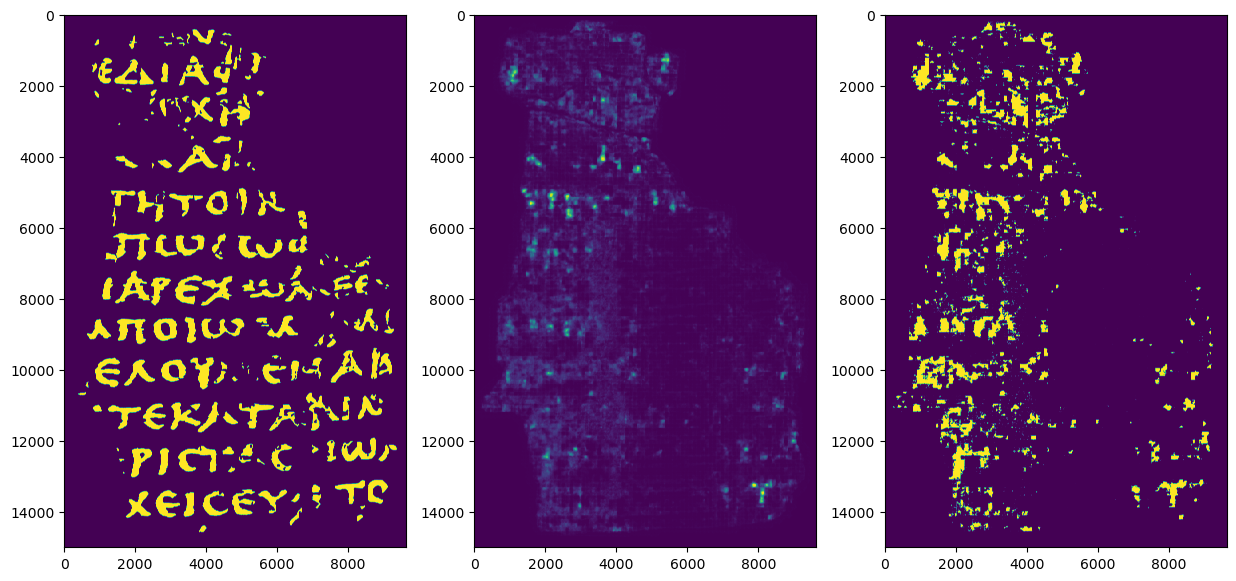

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.18895775e+08, 1.48350810e+07, 5.81740100e+06, 2.16943700e+06,
        8.69216000e+05, 5.31458000e+05, 3.47260000e+05, 2.66259000e+05,
        1.93359000e+05, 1.46917000e+05, 1.18285000e+05, 1.00866000e+05,
        6.81520000e+04, 5.23400000e+04, 4.77690000e+04, 3.81960000e+04,
        2.18340000e+04, 1.25340000e+04, 1.63440000e+04, 8.57300000e+03]),
 array([3.21005733e-04, 4.66636466e-02, 9.30062875e-02, 1.39348928e-01,
        1.85691569e-01, 2.32034210e-01, 2.78376851e-01, 3.24719492e-01,
        3.71062133e-01, 4.17404774e-01, 4.63747414e-01, 5.10090055e-01,
        5.56432696e-01, 6.02775337e-01, 6.49117978e-01, 6.95460619e-01,
        7.41803260e-01, 7.88145901e-01, 8.34488541e-01, 8.80831182e-01,
        9.27173823e-01]),
 <BarContainer object of 20 artists>)

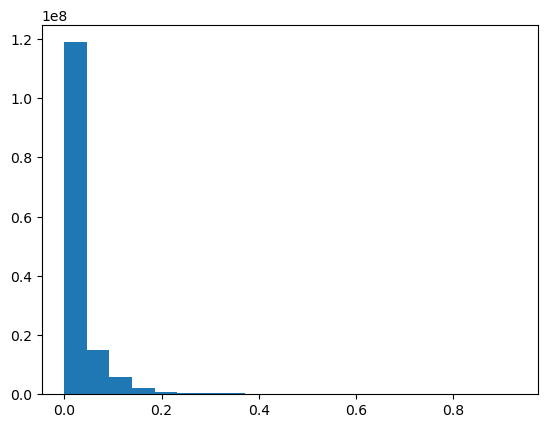

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000